# Assignment 2

## Instructions
- Your submission should be the `.ipynb` file with your name,
  like `FirstnameLastname.ipynb`. it should include the answers to the questions in
  markdown cells.
- You are expected to follow the best practices for code writing and model
training. Poor coding style will be penalized.
- You are allowed to discuss ideas with your peers, but no sharing of code.
Plagiarism in the code will result in failing. If you use code from the
internet, cite it by adding the source of the code as a comment in the first line of the code cell.
- In real life clients can give unclear goals or requirements. So, if the instructions seem vague, use common sense to make reasonable assumptions.

# Task 1: [Where's Waldo?](https://www.wikihow.com/Find-Waldo) (35 points)

## Fingerprinting
Browser fingerprinting is a technique used to identify and track individuals based on unique characteristics of their web browser configuration. These characteristics can include the browser type, version, installed plugins, and screen resolution, among others. By combining these attributes, websites can create a digital fingerprint that can be used to track user behavior across multiple sites, even if they clear their cookies or use different devices. This has raised concerns about privacy and the potential for this technology to be used for targeted advertising, surveillance, and other purposes.

[Read more]([Fingerprinting](https://datadome.co/learning-center/browser-fingerprinting-techniques/))

##  What you need to do
For this task, you are required to build a fully connect feed-forward ANN model
for a classification problem.

For the given data, you need do proper data preprocessing, data analysis,
design the ANN model, then fine-tune your model architecture.

For evaluating your model, do $ 80/20 $ train test split.

### Learning Objectives

- Select and implement suitable data preprocessing techniques. 10%
- Identify the appropriate classification approach for a given problem. 20%
- Apply ANNs to solve a classification problem (basic training, validation, testing -- without fine tuning). 50%
- Fine-tune to determine the optimal model architecture. 20%


### Data
You will be working with the data in `Task_1.csv` for identifying waldo (the user with `user_id=0`) 

The columns include:
 - browser
 - os
 - locale
 - user_id
 - location
 - sites
 - time
 - date

After training, evaluate you model by print [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
on your test set. 

Then predicting each user in `task_1_verify.csv` whether it's Waldo or not. Your output should look like the following:

`row_idx: is_waldo`, notice if the user is waldo your output should be 1

``` 
0: 1
1: 0
2: 0
3: 1
4: 1
...
```



### Importing modules for this lab.

In [2]:
import os
import copy
import cv2
import graphviz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as t

from time import time
from tqdm import tqdm
from zipfile import ZipFile
from io import BytesIO
from PIL import Image

from sklearn import tree
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier  

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


### Reading the csv file and printing it.

In [115]:
df = pd.read_csv("/kaggle/input/imls23-assignment2/task 1.csv")
df

,index,browser,os,locale,user_id,location,sites,time,date
0,8909,Firefox,Windows 10,zh-CN,46,China/Shanghai,"[{'site': '1.static.dpreview.com', 'length': 1...",14:14:00,2016-01-28
1,17679,Internet Explorer,Windows 8,ro-RO,21,Germany/Berlin,"[{'site': 'safebrowsing-cache.google.com', 'le...",05:23:00,2016-08-26
2,11803,Internet Explorer,MacOS,ur-PK,98,Australia/Sydney,"[{'site': 'www.ncbi.nlm.nih.gov', 'length': 10...",12:03:00,2016-03-13
3,356,Internet Explorer,Ubuntu,pl-PL,44,Japan/Tokyo,"[{'site': 'fr.hdscreen.me', 'length': 16}, {'s...",06:08:00,2017-01-19
4,10948,Internet Explorer,Windows 8,bg-BG,59,Japan/Tokyo,"[{'site': '193.164.196.50', 'length': 10}, {'s...",03:59:00,2017-05-13
...,...,...,...,...,...,...,...,...,...
20396,9076,Safari,Windows 10,es-MX,55,Japan/Tokyo,"[{'site': 's.youtube.com', 'length': 168}, {'s...",05:02:00,2016-08-02
20397,11021,Chrome,Debian,en-US,37,UK/London,"[{'site': 'ajax.googleapis.com', 'length': 122...",22:20:00,2017-01-14
20398,11616,Chrome,Windows 10,ro-RO,175,USA/Chicago,"[{'site': 'blast.ncbi.nlm.nih.gov', 'length': ...",04:06:00,2016-11-05
20399,1863,Firefox,Ubuntu,vi-VN,142,China/Shanghai,"[{'site': 'www.google.fr', 'length': 9}, {'sit...",10:31:00,2016-08-01


### In the given dataset, no column contains a null value. Thus, we can skip the dataset infusion process.

### However, only two columns have strictly defined data types: **index** and **user_id**. Other columns are objects that have to be converted to integers or floats.

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20401 entries, 0 to 20400
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     20401 non-null  int64 
 1   browser   20401 non-null  object
 2   os        20401 non-null  object
 3   locale    20401 non-null  object
 4   user_id   20401 non-null  int64 
 5   location  20401 non-null  object
 6   sites     20401 non-null  object
 7   time      20401 non-null  object
 8   date      20401 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.4+ MB


### We can get rid of 'index' column because the same function has the index of a row in a pandas dataframe.

### I am also making a naive assumption that both 'date' and 'time' columns will not affect the prediction.

In [117]:
df = df.drop(['index', 'time', 'date', 'sites'], axis='columns')
df

,browser,os,locale,user_id,location
0,Firefox,Windows 10,zh-CN,46,China/Shanghai
1,Internet Explorer,Windows 8,ro-RO,21,Germany/Berlin
2,Internet Explorer,MacOS,ur-PK,98,Australia/Sydney
3,Internet Explorer,Ubuntu,pl-PL,44,Japan/Tokyo
4,Internet Explorer,Windows 8,bg-BG,59,Japan/Tokyo
...,...,...,...,...,...
20396,Safari,Windows 10,es-MX,55,Japan/Tokyo
20397,Chrome,Debian,en-US,37,UK/London
20398,Chrome,Windows 10,ro-RO,175,USA/Chicago
20399,Firefox,Ubuntu,vi-VN,142,China/Shanghai


### Split values of dataframe into X and y dataframes

In [118]:
y = df.loc[:, 'user_id']
X = df.drop('user_id', axis='columns')

### Encode values of y.

In [119]:
y = y.apply(lambda x: 0 if x != 0 else 1)
y

0        0
1        0
2        0
3        0
4        0
        ..
20396    0
20397    0
20398    0
20399    0
20400    0
Name: user_id, Length: 20401, dtype: int64

### Check the "is_waldo" class balance.

[Text(0, 0, '20001'), Text(0, 0, '400')]

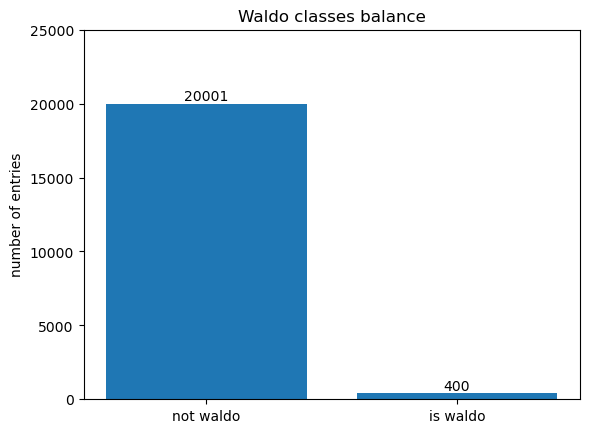

In [120]:
is_waldo = y.loc[lambda x: x == 1]
not_waldo = y.loc[lambda x: x == 0]

fig, ax = plt.subplots()
bar_container = ax.bar(['not waldo', 'is waldo'], [len(not_waldo), len(is_waldo)])
ax.set(ylabel='number of entries', title='Waldo classes balance', ylim=(0, 25000))
ax.bar_label(bar_container)

### The given data is highly unbalanced, so the optimisation metric for this task will be f1 score.

### Apply One-Hot Encoding on 'browser', 'os', 'locale', 'location', and 'sites' columns

reference: https://datagy.io/sklearn-one-hot-encode/

In [121]:
X = pd.get_dummies(X, columns=['locale', 'location'])

transformer = make_column_transformer(
    (OneHotEncoder(), ['browser', 'os']),
    remainder='passthrough'
)

transformed = transformer.fit_transform(X)
transformed_X = pd.DataFrame(
    transformed,
    columns=transformer.get_feature_names_out()
)
transformed_X

,onehotencoder__browser_Chrome,onehotencoder__browser_Firefox,onehotencoder__browser_Internet Explorer,onehotencoder__browser_Safari,onehotencoder__os_Debian,onehotencoder__os_MacOS,onehotencoder__os_Ubuntu,onehotencoder__os_Windows 10,onehotencoder__os_Windows 7,onehotencoder__os_Windows 8,...,remainder__location_Netherlands/Amsterdam,remainder__location_New Zealand/Auckland,remainder__location_Russia/Moscow,remainder__location_Singapore/Singapore,remainder__location_Spain/Madrid,remainder__location_UK/London,remainder__location_USA/Chicago,remainder__location_USA/Miami,remainder__location_USA/New York,remainder__location_USA/San Francisco
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20396,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20397,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
20398,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
20399,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Perform Train-Test split with ratio 80/20

In [122]:
X_train, X_test, y_train, y_test = train_test_split(transformed_X, y, test_size=0.2, random_state=42, stratify=y)

In [123]:
X_train

,onehotencoder__browser_Chrome,onehotencoder__browser_Firefox,onehotencoder__browser_Internet Explorer,onehotencoder__browser_Safari,onehotencoder__os_Debian,onehotencoder__os_MacOS,onehotencoder__os_Ubuntu,onehotencoder__os_Windows 10,onehotencoder__os_Windows 7,onehotencoder__os_Windows 8,...,remainder__location_Netherlands/Amsterdam,remainder__location_New Zealand/Auckland,remainder__location_Russia/Moscow,remainder__location_Singapore/Singapore,remainder__location_Spain/Madrid,remainder__location_UK/London,remainder__location_USA/Chicago,remainder__location_USA/Miami,remainder__location_USA/New York,remainder__location_USA/San Francisco
11158,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
687,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7683,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5278,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2264,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3165,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5698,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13850,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17443,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Last step in the data preprocessing is the visualisation of correlation between the features.

In [124]:
plt.figure(figsize=(30, 30))
corr = X_train.corr()
corr.style.format(precision=2).background_gradient(cmap='Oranges')  # Open in Google Colab for better view

,onehotencoder__browser_Chrome,onehotencoder__browser_Firefox,onehotencoder__browser_Internet Explorer,onehotencoder__browser_Safari,onehotencoder__os_Debian,onehotencoder__os_MacOS,onehotencoder__os_Ubuntu,onehotencoder__os_Windows 10,onehotencoder__os_Windows 7,onehotencoder__os_Windows 8,remainder__locale_bg-BG,remainder__locale_de-DE,remainder__locale_en-AU,remainder__locale_en-CA,remainder__locale_en-GB,remainder__locale_en-NZ,remainder__locale_en-SG,remainder__locale_en-US,remainder__locale_es-MX,remainder__locale_fr-FR,remainder__locale_it-IT,remainder__locale_ja-JP,remainder__locale_nl-NL,remainder__locale_pl-PL,remainder__locale_pt-BR,remainder__locale_pt-PT,remainder__locale_ro-RO,remainder__locale_ru-RU,remainder__locale_ru_RU,remainder__locale_uk-UA,remainder__locale_ur-PK,remainder__locale_vi-VN,remainder__locale_wo-SN,remainder__locale_xh-ZA,remainder__locale_zh-CN,remainder__location_Australia/Sydney,remainder__location_Brazil/Rio de Janeiro,remainder__location_Canada/Toronto,remainder__location_Canada/Vancouver,remainder__location_China/Shanghai,remainder__location_France/Paris,remainder__location_Germany/Berlin,remainder__location_India/Delhi,remainder__location_Italy/Rome,remainder__location_Japan/Tokyo,remainder__location_Malaysia/Kuala Lumpur,remainder__location_Netherlands/Amsterdam,remainder__location_New Zealand/Auckland,remainder__location_Russia/Moscow,remainder__location_Singapore/Singapore,remainder__location_Spain/Madrid,remainder__location_UK/London,remainder__location_USA/Chicago,remainder__location_USA/Miami,remainder__location_USA/New York,remainder__location_USA/San Francisco
onehotencoder__browser_Chrome,1.00,-0.55,-0.28,-0.40,0.00,-0.01,0.01,0.00,-0.00,0.00,-0.00,0.01,-0.00,0.01,0.00,-0.01,0.01,0.01,-0.01,-0.00,-0.01,-0.00,-0.01,-0.00,0.02,-0.01,-0.00,-0.00,0.01,-0.01,0.00,0.00,-0.00,0.01,-0.01,0.00,-0.00,0.01,-0.01,0.01,-0.00,-0.01,0.02,-0.01,-0.01,-0.00,-0.00,-0.01,-0.01,0.01,0.01,0.00,0.01,0.01,-0.01,-0.00
onehotencoder__browser_Firefox,-0.55,1.00,-0.22,-0.31,-0.00,0.00,0.01,0.00,0.01,-0.02,-0.01,-0.01,-0.01,-0.02,-0.01,-0.00,-0.01,-0.01,0.00,-0.00,0.01,-0.00,0.00,0.00,-0.02,0.01,0.00,-0.01,0.03,0.01,0.01,0.01,0.00,0.00,0.01,-0.01,-0.01,0.01,0.02,-0.01,0.02,0.01,-0.02,0.01,-0.00,0.01,0.00,-0.01,-0.00,-0.00,-0.01,-0.01,0.02,-0.01,-0.01,-0.01
onehotencoder__browser_Internet Explorer,-0.28,-0.22,1.00,-0.16,-0.01,0.01,-0.01,-0.01,0.00,0.01,0.01,0.00,-0.02,0.00,0.00,0.00,-0.00,0.00,0.01,-0.00,-0.01,-0.00,-0.01,0.01,-0.01,0.01,0.00,0.02,-0.02,0.00,-0.01,-0.00,0.00,0.01,-0.00,0.00,-0.01,-0.00,0.01,0.01,-0.00,0.01,0.00,-0.00,0.00,-0.01,-0.00,0.00,0.01,-0.02,0.00,-0.00,-0.01,0.00,-0.00,0.00
onehotencoder__browser_Safari,-0.40,-0.31,-0.16,1.00,0.01,0.00,-0.02,0.00,-0.01,0.01,0.01,-0.00,0.02,0.01,0.01,0.02,0.00,-0.00,-0.00,0.00,0.01,0.00,0.02,-0.01,0.00,-0.00,-0.01,-0.01,-0.04,0.00,-0.01,-0.01,-0.00,-0.02,0.00,0.01,0.01,-0.02,-0.01,-0.01,-0.02,-0.01,-0.01,-0.00,0.02,0.00,0.00,0.01,0.00,0.00,-0.00,0.01,-0.03,0.00,0.02,0.01
onehotencoder__os_Debian,0.00,-0.00,-0.01,0.01,1.00,-0.12,-0.08,-0.20,-0.07,-0.10,-0.01,0.01,-0.01,0.01,0.01,0.02,-0.01,0.01,-0.01,0.01,-0.00,0.01,-0.00,-0.00,-0.01,0.00,0.01,-0.01,-0.03,0.01,-0.01,0.01,-0.00,-0.01,0.01,0.01,-0.00,0.00,0.00,0.00,-0.01,-0.00,0.00,0.01,0.01,-0.01,-0.01,0.01,0.00,-0.00,-0.01,0.00,-0.01,0.01,-0.00,-0.02
onehotencoder__os_MacOS,-0.01,0.00,0.01,0.00,-0.12,1.00,-0.16,-0.41,-0.15,-0.21,0.00,-0.00,0.01,-0.00,0.01,-0.00,-0.00,-0.00,-0.00,-0.01,0.00,0.01,0.00,0.01,0.01,0.01,0.00,0.01,-0.05,-0.01,0.00,0.01,0.00,0.02,-0.00,-0.01,-0.00,-0.01,0.01,0.01,-0.02,-0.00,0.00,0.01,0.00,-0.00,-0.01,0.00,0.00,0.01,-0.00,-0.00,-0.02,0.00,0.01,0.01
onehotencoder__os_Ubuntu,0.01,0.01,-0.01,-0.02,-0.08,-0.16,1.00,-0.28,-0.10,-0.14,-0.01,0.00,-0.02,-0.01,-0.01,0.00,-0.01,0.00,0.00,0.00,-0.01,-0.00,-0.01,0.01,-0.00,-0.02,-0.01,0.00,0.11,-0.00,0.00,-0.00,-0.01,-0.02,-0.01,-0.01,-0.01,0.01,-0.01,-0.00,0.01,-0.00,-0.01,0.00,0.00,-0.02,-0.00,0.00,-0.00,-0.02,-0.01,-0.02,0.06,-0.00,0

<Figure size 3000x3000 with 0 Axes>

### From the table we can observe almost zero correlation between every feature. However, there are some noticeable values between Firefox-Chrome, Chrome-Safari, and Firefox-Safari. This will definitely account into prediction.

### Finally, we can start building the model.

references:

https://visualstudiomagazine.com/Articles/2021/02/11/pytorch-define.aspx?Page=2

https://towardsdatascience.com/logistic-regression-with-pytorch-3c8bbea594be

In [125]:
# Device configuration
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [126]:
class LogisticRegressionANN(t.nn.Module):
    def __init__(self):
        super(LogisticRegressionANN, self).__init__()
        self.fc1 = t.nn.Linear(56, 10)
        self.fc2 = t.nn.Linear(10, 10)
        self.fc3 = t.nn.Linear(10, 1)

        t.nn.init.xavier_uniform_(self.fc1.weight)
        t.nn.init.zeros_(self.fc1.bias)
        t.nn.init.xavier_uniform_(self.fc2.weight)
        t.nn.init.zeros_(self.fc2.bias)
        t.nn.init.xavier_uniform_(self.fc3.weight)
        t.nn.init.zeros_(self.fc3.bias)

    # x - batch of one or more tensors.
    def forward(self, x):
        z = t.relu(self.fc1(x))
        z = t.relu(self.fc2(z))
        z = t.sigmoid(self.fc3(z))
        return z

### Initialising the model.

In [127]:
model = LogisticRegressionANN()

epochs = 350
learning_rate = 0.01
criterion = t.nn.BCELoss()
optimizer = t.optim.Adam(model.parameters(), lr=learning_rate)

### Converting input data to tensors.

In [128]:
X_train, X_test = t.Tensor(X_train.values), t.Tensor(X_test.values)
y_train, y_test = t.Tensor(y_train.values), t.Tensor(y_test.values)

### Building the training loop.

In [129]:
# Trains the pytorch model.
def train_model():
    losses = []
    losses_test = []
    Iterations = []
    iter = 0
    
    for epoch in tqdm(range(int(epochs)), desc='Training Epochs'):
        x = X_train
        labels = y_train
        optimizer.zero_grad() # Setting our stored gradients equal to zero
        outputs = model(X_train)
        loss = criterion(t.squeeze(outputs), labels)

        loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias

        optimizer.step() # Updates weights and biases with the optimizer (SGD)

        iter += 1
        if iter % 10 == 0:
            with t.no_grad():
                # Calculating the loss and f1 score for the test dataset
                prediction = model(X_test)
                outputs_test = t.squeeze(prediction)
                loss_test = criterion(outputs_test, y_test)

                predicted_test = outputs_test.round().detach().numpy()
                f1_test = f1_score(y_true=y_test, y_pred=predicted_test)
                print(predicted_test)
                losses_test.append(loss_test.item())

                # Calculating the loss and f1 score for the train dataset
                predicted_train = t.squeeze(outputs).round().detach().numpy()
                f1_train = f1_score(y_true=y_train, y_pred=predicted_train)
                losses.append(loss.item())
                Iterations.append(iter)

                print(f"\nIteration: {iter}. \nTest - Loss: {loss_test.item()}. F1 score: {f1_test}")
                print(f"Train -  Loss: {loss.item()}. F1 score: {f1_train}\n")

### Model training.

In [130]:
train_model()

Training Epochs:  10%|▉         | 34/350 [00:00<00:01, 174.25it/s]

[0. 0. 0. ... 0. 0. 0.]

Iteration: 10. 
Test - Loss: 0.14662033319473267. F1 score: 0.0
Train -  Loss: 0.17944437265396118. F1 score: 0.0

[0. 0. 0. ... 0. 0. 0.]

Iteration: 20. 
Test - Loss: 0.06411296874284744. F1 score: 0.0
Train -  Loss: 0.06563322246074677. F1 score: 0.0

[0. 0. 0. ... 0. 0. 0.]

Iteration: 30. 
Test - Loss: 0.046546753495931625. F1 score: 0.0
Train -  Loss: 0.049687713384628296. F1 score: 0.0

[0. 0. 0. ... 0. 0. 0.]

Iteration: 40. 
Test - Loss: 0.03252650424838066. F1 score: 0.0
Train -  Loss: 0.03346622735261917. F1 score: 0.0

[0. 0. 0. ... 0. 0. 0.]

Iteration: 50. 
Test - Loss: 0.029185974970459938. F1 score: 0.0
Train -  Loss: 0.028960801661014557. F1 score: 0.0



Training Epochs:  30%|███       | 105/350 [00:00<00:01, 220.31it/s]

[0. 0. 0. ... 0. 0. 0.]

Iteration: 60. 
Test - Loss: 0.027329249307513237. F1 score: 0.0
Train -  Loss: 0.027081558480858803. F1 score: 0.0

[0. 0. 0. ... 0. 0. 0.]

Iteration: 70. 
Test - Loss: 0.02526836469769478. F1 score: 0.0
Train -  Loss: 0.025180445984005928. F1 score: 0.0

[0. 0. 0. ... 0. 0. 0.]

Iteration: 80. 
Test - Loss: 0.023611044511198997. F1 score: 0.0
Train -  Loss: 0.023566192016005516. F1 score: 0.0

[0. 0. 0. ... 0. 0. 0.]

Iteration: 90. 
Test - Loss: 0.022279521450400352. F1 score: 0.0
Train -  Loss: 0.02227674052119255. F1 score: 0.0

[0. 0. 0. ... 0. 0. 0.]

Iteration: 100. 
Test - Loss: 0.02111540548503399. F1 score: 0.0
Train -  Loss: 0.021108392626047134. F1 score: 0.0



Training Epochs:  43%|████▎     | 152/350 [00:00<00:00, 220.27it/s]

[0. 0. 0. ... 0. 0. 0.]

Iteration: 110. 
Test - Loss: 0.020016465336084366. F1 score: 0.0
Train -  Loss: 0.0200123842805624. F1 score: 0.0

[0. 0. 0. ... 0. 0. 0.]

Iteration: 120. 
Test - Loss: 0.019017281010746956. F1 score: 0.0
Train -  Loss: 0.01900472119450569. F1 score: 0.0

[0. 0. 0. ... 0. 0. 0.]

Iteration: 130. 
Test - Loss: 0.01806112751364708. F1 score: 0.0
Train -  Loss: 0.018044933676719666. F1 score: 0.0

[0. 0. 0. ... 0. 0. 0.]

Iteration: 140. 
Test - Loss: 0.017191477119922638. F1 score: 0.0
Train -  Loss: 0.01712767593562603. F1 score: 0.0

[0. 0. 0. ... 0. 0. 0.]

Iteration: 150. 
Test - Loss: 0.016580704599618912. F1 score: 0.0
Train -  Loss: 0.016486594453454018. F1 score: 0.0



Training Epochs:  57%|█████▋    | 198/350 [00:00<00:00, 224.28it/s]

[0. 0. 0. ... 0. 0. 0.]

Iteration: 160. 
Test - Loss: 0.01612931117415428. F1 score: 0.0
Train -  Loss: 0.015998808667063713. F1 score: 0.0

[0. 0. 0. ... 0. 0. 0.]

Iteration: 170. 
Test - Loss: 0.0158236064016819. F1 score: 0.0
Train -  Loss: 0.015662461519241333. F1 score: 0.0

[0. 0. 0. ... 0. 0. 0.]

Iteration: 180. 
Test - Loss: 0.01561299990862608. F1 score: 0.0
Train -  Loss: 0.015430277213454247. F1 score: 0.0

[0. 0. 0. ... 0. 0. 0.]

Iteration: 190. 
Test - Loss: 0.015421601943671703. F1 score: 0.0
Train -  Loss: 0.015217984095215797. F1 score: 0.0

[0. 0. 0. ... 0. 0. 0.]

Iteration: 200. 
Test - Loss: 0.015242978930473328. F1 score: 0.0
Train -  Loss: 0.015025481581687927. F1 score: 0.0



Training Epochs:  70%|██████▉   | 244/350 [00:01<00:00, 222.06it/s]

[0. 0. 0. ... 0. 1. 0.]

Iteration: 210. 
Test - Loss: 0.015067645348608494. F1 score: 0.963855421686747
Train -  Loss: 0.014836606569588184. F1 score: 0.975609756097561

[0. 0. 0. ... 0. 1. 0.]

Iteration: 220. 
Test - Loss: 0.01490431185811758. F1 score: 0.963855421686747
Train -  Loss: 0.014661560766398907. F1 score: 0.975609756097561

[0. 0. 0. ... 0. 1. 0.]

Iteration: 230. 
Test - Loss: 0.014741659164428711. F1 score: 0.963855421686747
Train -  Loss: 0.014489907771348953. F1 score: 0.975609756097561

[0. 0. 0. ... 0. 1. 0.]

Iteration: 240. 
Test - Loss: 0.014584245160222054. F1 score: 0.963855421686747
Train -  Loss: 0.014322041533887386. F1 score: 0.975609756097561

[0. 0. 0. ... 0. 1. 0.]

Iteration: 250. 
Test - Loss: 0.014428667724132538. F1 score: 0.963855421686747
Train -  Loss: 0.014156760647892952. F1 score: 0.975609756097561



Training Epochs:  83%|████████▎ | 291/350 [00:01<00:00, 224.53it/s]

[0. 0. 0. ... 0. 1. 0.]

Iteration: 260. 
Test - Loss: 0.01427632849663496. F1 score: 0.963855421686747
Train -  Loss: 0.013994657434523106. F1 score: 0.975609756097561

[0. 0. 0. ... 0. 1. 0.]

Iteration: 270. 
Test - Loss: 0.014122340828180313. F1 score: 0.963855421686747
Train -  Loss: 0.013834760524332523. F1 score: 0.975609756097561

[0. 0. 0. ... 0. 1. 0.]

Iteration: 280. 
Test - Loss: 0.013970804400742054. F1 score: 0.963855421686747
Train -  Loss: 0.013675220310688019. F1 score: 0.975609756097561

[0. 0. 0. ... 0. 1. 0.]

Iteration: 290. 
Test - Loss: 0.013821909204125404. F1 score: 0.963855421686747
Train -  Loss: 0.013518820516765118. F1 score: 0.975609756097561

[0. 0. 0. ... 0. 1. 0.]

Iteration: 300. 
Test - Loss: 0.01367455068975687. F1 score: 0.963855421686747
Train -  Loss: 0.01336405798792839. F1 score: 0.975609756097561



Training Epochs: 100%|██████████| 350/350 [00:01<00:00, 216.44it/s]

[0. 0. 0. ... 0. 1. 0.]

Iteration: 310. 
Test - Loss: 0.013531395234167576. F1 score: 0.963855421686747
Train -  Loss: 0.01321331411600113. F1 score: 0.975609756097561

[0. 0. 0. ... 0. 1. 0.]

Iteration: 320. 
Test - Loss: 0.013383795507252216. F1 score: 0.963855421686747
Train -  Loss: 0.013059105724096298. F1 score: 0.975609756097561

[0. 0. 0. ... 0. 1. 0.]

Iteration: 330. 
Test - Loss: 0.013246848247945309. F1 score: 0.963855421686747
Train -  Loss: 0.012911699712276459. F1 score: 0.975609756097561

[0. 0. 0. ... 0. 1. 0.]

Iteration: 340. 
Test - Loss: 0.013099375180900097. F1 score: 0.963855421686747
Train -  Loss: 0.012759171426296234. F1 score: 0.975609756097561

[0. 0. 0. ... 0. 1. 0.]

Iteration: 350. 
Test - Loss: 0.012957477942109108. F1 score: 0.963855421686747
Train -  Loss: 0.012611872516572475. F1 score: 0.975609756097561



### Classification report on the test dataset.

In [131]:
predictions = model(X_test).round().detach().numpy()
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4001
         1.0       0.93      1.00      0.96        80

    accuracy                           1.00      4081
   macro avg       0.97      1.00      0.98      4081
weighted avg       1.00      1.00      1.00      4081



In [132]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
fc1.weight 	 torch.Size([10, 56])
fc1.bias 	 torch.Size([10])
fc2.weight 	 torch.Size([10, 10])
fc2.bias 	 torch.Size([10])
fc3.weight 	 torch.Size([1, 10])
fc3.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {0: {'step': tensor(350.), 'exp_avg': tensor([[-4.7317e-08, -7.3522e-08, -1.0480e-09, -3.9274e-11, -1.4041e-11,
         -1.5799e-11, -3.8575e-08, -8.2182e-08, -9.1093e-10, -2.2901e-10,
         -6.7777e-10,  1.0026e-20, -1.6780e-10,  1.9885e-20,  1.0832e-20,
          4.5773e-20, -1.0968e-10, -1.4224e-12,  2.5260e-21,  9.6070e-21,
          9.7371e-22, -8.0631e-09, -3.6726e-10,  1.2860e-20, -1.1183e-07,
         -1.0712e-10,  1.3045e-20, -1.5732e-12,  1.3625e-19,  1.0831e-20,
          1.2120e-20, -1.1793e-10, -4.8311e-10, -3.6595e-12,  6.6963e-21,
         -3.2307e-11, -4.3762e-10, -3.3390e-08, -2.6976e-10, -4.7461e-10,
         -4.6232e-08, -1.0838e-09, -3.7826e-10,  3.3213e-21, -1.0424e-10,
         -7.3092e-11, -1.0674e-12, -1.5529e-10, -2.7001e-10,

### Finetuning the model

references: 

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [133]:
# Number of classes in the dataset
num_classes = 1

# Number of epochs to train for
num_epochs = 250

# Splitting train and test data into dictionary.
dataloaders_dict = {'train': (X_train, y_train), 'val': (X_test, y_test)}

In [134]:
# Handles the training and validation of the pytorch model.
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0.0
                
            inputs = dataloaders_dict[phase][0].to(device)
            labels = dataloaders_dict[phase][1].to(device).reshape(-1, 1)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with t.set_grad_enabled(phase == 'train'):
                # Get model outputs and calculate loss
                
                outputs = model(inputs).reshape(-1, 1)
                loss = criterion(outputs, labels)

                preds = t.round(outputs)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += t.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders_dict[phase][0])
            epoch_acc = running_corrects.double() / len(dataloaders_dict[phase][0])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [135]:
def initialize_model(num_classes):
    model_ft = model
    
    model_ft.fc3 = t.nn.Linear(10, num_classes)

    return model_ft


# Initialize the model for this run
model_ft = initialize_model(num_classes)

# Print the model we just instantiated
print(model_ft)

LogisticRegressionANN(
  (fc1): Linear(in_features=56, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)


In [136]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. 
# For finetuning we will be updating all parameters.
params_to_update = model_ft.parameters()
print("Params to learn:")

for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

Params to learn:
	 fc1.weight
	 fc1.bias
	 fc2.weight
	 fc2.bias
	 fc3.weight
	 fc3.bias


### Fine-tune model.

In [137]:
# Train and evaluate
optimizer = t.optim.Adam(model.parameters(), lr=learning_rate)
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/249
----------
train Loss: 0.7732 Acc: 0.1155
val Loss: 0.6084 Acc: 0.8691

Epoch 1/249
----------
train Loss: 0.6072 Acc: 0.8784
val Loss: 0.4718 Acc: 0.9944

Epoch 2/249
----------
train Loss: 0.4709 Acc: 0.9925
val Loss: 0.3609 Acc: 0.9980

Epoch 3/249
----------
train Loss: 0.3602 Acc: 0.9979
val Loss: 0.2733 Acc: 0.9985

Epoch 4/249
----------
train Loss: 0.2728 Acc: 0.9989
val Loss: 0.2061 Acc: 0.9951

Epoch 5/249
----------
train Loss: 0.2057 Acc: 0.9945
val Loss: 0.1558 Acc: 0.9804

Epoch 6/249
----------
train Loss: 0.1555 Acc: 0.9804
val Loss: 0.1190 Acc: 0.9804

Epoch 7/249
----------
train Loss: 0.1188 Acc: 0.9804
val Loss: 0.0925 Acc: 0.9804

Epoch 8/249
----------
train Loss: 0.0924 Acc: 0.9804
val Loss: 0.0738 Acc: 0.9804

Epoch 9/249
----------
train Loss: 0.0738 Acc: 0.9804
val Loss: 0.0607 Acc: 0.9804

Epoch 10/249
----------
train Loss: 0.0607 Acc: 0.9804
val Loss: 0.0517 Acc: 0.9804

Epoch 11/249
----------
train Loss: 0.0517 Acc: 0.9804
val Loss: 0.0455 Acc

### Compare fine-tunned model on the task_1_verify.csv with pre fine-tunned one.

In [138]:
verify_df = pd.read_csv("/kaggle/input/imls23-assignment2/task_1_verify.csv")
verify_df = verify_df.drop(['time', 'date'], axis='columns')

X = verify_df.drop('sites', axis='columns')

X = pd.get_dummies(X, columns=['locale', 'location'])

transformer = make_column_transformer(
    (OneHotEncoder(), ['browser', 'os']),
    remainder='passthrough'
)

transformed = transformer.fit_transform(X)
new_transformed_X = pd.DataFrame(
    transformed,
    columns=transformer.get_feature_names_out()
)

new_df = pd.DataFrame(data=new_transformed_X, columns=transformed_X.columns)
new_df

,onehotencoder__browser_Chrome,onehotencoder__browser_Firefox,onehotencoder__browser_Internet Explorer,onehotencoder__browser_Safari,onehotencoder__os_Debian,onehotencoder__os_MacOS,onehotencoder__os_Ubuntu,onehotencoder__os_Windows 10,onehotencoder__os_Windows 7,onehotencoder__os_Windows 8,...,remainder__location_Netherlands/Amsterdam,remainder__location_New Zealand/Auckland,remainder__location_Russia/Moscow,remainder__location_Singapore/Singapore,remainder__location_Spain/Madrid,remainder__location_UK/London,remainder__location_USA/Chicago,remainder__location_USA/Miami,remainder__location_USA/New York,remainder__location_USA/San Francisco
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,1.0,NaN
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,1.0,0.0,NaN,0.0,NaN
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN
7,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN


### In the task_1_verify we have some columns missing, i.e. 45 columns in total. However, in the task1.csv dataset we have 56 columns, so we need to find which encoded values are missing.

In [139]:
missing_columns = transformed_X.columns.difference(new_transformed_X.columns)
missing_columns

Index(['remainder__locale_bg-BG', 'remainder__locale_en-SG',
       'remainder__locale_es-MX', 'remainder__locale_it-IT',
       'remainder__locale_ja-JP', 'remainder__locale_ro-RO',
       'remainder__locale_wo-SN', 'remainder__location_Malaysia/Kuala Lumpur',
       'remainder__location_Singapore/Singapore',
       'remainder__location_USA/Miami',
       'remainder__location_USA/San Francisco'],
      dtype='object')

### I have decided to impute missing columns with constant strategy.

In [140]:
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.0)
imputed_values = imputer.fit_transform(new_df)
imputed_values

array([[0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

### Now let's test fine-tunned model and pre fine-tunned model.

In [141]:
tensor_X = t.Tensor(imputed_values).to(device)
new_predictions = model_ft(tensor_X).round()
new_predictions

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [142]:
tensor_X = t.Tensor(imputed_values).to(device)
model(tensor_X).round()

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0', grad_fn=<RoundBackward0>)

### Questions
1. Did you find any useful insights from your data analysis?
    - Yes, the useful insights I have found are:
    -- The dataset is highly unbalanced. Only 40 Waldos among 20001 entries.
    -- The dataset does not include any NaN values.
    -- Almost all features should be encoded.
2. What preprocessing techniques did you use? Why?
    - One-hot encoding. It is a good method for this task because we have many repeating categorical values that can be encoded into seperate columns.
    - Correlation matrix. I wanted to check if there are any highly-correlated features in the dataset. As I found out, there were none.
    - Identifying the balance between classes. This technique helped to identify which optimisation metric I should use.
3. Describe the fine-tuning process and how you reached your model architecture.
    - First, I have started from only one layer and build all the way to 3 layers, while testing the f1 score.
    - Second, I have "frozen" first two fully-connected layers of the model and re-trained the last layer once again.
    - Lastly, I have checked the losses, and the fine-tunned model has shown a slight improvement.
4. Which metric did you try to optimize for this task? Why?
    - I have used f1 score because the dataset is highly unbalanced, and that is why one should take into an account both recall and precision.

# Task 2: Fingerprint Recognition (50 points)
Fingerprint recognition is a highly accurate and reliable biometric technology that is used for identification and authentication purposes. By analyzing the unique patterns and ridges on an individual's fingerprint, it is possible to verify their identity with a high degree of confidence. This technology is widely used in law enforcement, border control, and access control systems, as well as in mobile devices and payment systems, to ensure secure and reliable identification and authentication.

In this task you will be doing a simplified version of Fingerprint ID, which is just identifying which finger is used in the image

## What you need to do

For this task, you will be doing image classification:
- Build a CNN model for image classification.
- Estimate the speed of inference of your model

For the given data, you need to do proper data preprocessing, augmentation, and data loaders.

Then fine-tune your model architecture to achieve the highest accuracy.

### Learning Objectives

- Select and implement suitable data preprocessing techniques. 10%
- Use literature (any paper on the use of CNN for fingerprinting and cite it) to choose an architecture. 10%
- Apply CNNs to solve an image classification problem (basic training, validation, testing -- without fine tuning). 40%
- Fine-tune your model to improve performance. 20%
- Use of data augmentation to improve model’s performance. 20%
- Explore beyond data augmentation find techniques to improve model’s performance and use them. 15%(bonus)


### Data
[Download link](https://drive.google.com/file/d/1iMIdYKSmCjVL5p-yzy-oInLMtTVt-1_j/view?usp=share_link)

You will be working with the data in `task_2.zip` for identifying. The name of each image consists of 2 parts like
`idx_label.BMB`

Where the idx is the index of the image and the label are the target class.

Each label corresponds to a finger:
```
0-> left_thumb
1-> left_index
2-> left_middle
3-> left_ring
4-> left_little
5-> right_thumb
6-> right_index
7-> right_middle
8-> right_ring
9-> right_little
```

### Write custom DataLoader class.

### In the given dataset, we have two different sizes of images, so we will have to scale them.

references:

https://www.geeksforgeeks.org/working-zip-files-python/

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [4]:
### If working in Kaggle - zip the dataset.
!cd /kaggle/working/
!mkdir task2
!zip -r -j /kaggle/working/task2/test.zip /kaggle/input/fingerprintdataset/test
!zip -r -j /kaggle/working/task2/train.zip /kaggle/input/fingerprintdataset/train
!zip -r -j /kaggle/working/task2.zip /kaggle/working/task2

  adding: 4695_9 (deflated 42%)
  adding: 13772_0 (deflated 23%)
  adding: 11512_7 (deflated 28%)
  adding: 8941_2 (deflated 26%)
  adding: 4112_4 (deflated 47%)
  adding: 11597_3 (deflated 36%)
  adding: 8163_0 (deflated 33%)
  adding: 8085_8 (deflated 33%)
  adding: 2359_7 (deflated 29%)
  adding: 7364_3 (deflated 30%)
  adding: 4641_6 (deflated 28%)
  adding: 10916_7 (deflated 42%)
  adding: 12627_1 (deflated 36%)
  adding: 8303_5 (deflated 31%)
  adding: 4273_0 (deflated 26%)
  adding: 3159_9 (deflated 48%)
  adding: 5263_5 (deflated 23%)
  adding: 9945_8 (deflated 24%)
  adding: 7830_6 (deflated 34%)
  adding: 6032_2 (deflated 25%)
  adding: 7141_5 (deflated 29%)
  adding: 4886_3 (deflated 23%)
  adding: 9244_5 (deflated 29%)
  adding: 8395_4 (deflated 51%)
  adding: 7319_9 (deflated 47%)
  adding: 2282_8 (deflated 35%)
  adding: 12183_0 (deflated 37%)
  adding: 2022_5 (deflated 30%)
  adding: 3991_6 (deflated 33%)
  adding: 31_0 (deflated 32%)
  adding: 10926_1 (deflated 39%)
  a

In [1]:
# # Clear output folder
# def remove_folder_contents(folder):
#     for the_file in os.listdir(folder):
#         file_path = os.path.join(folder, the_file)
#         try:
#             if os.path.isfile(file_path):
#                 os.unlink(file_path)
#             elif os.path.isdir(file_path):
#                 remove_folder_contents(file_path)
#                 os.rmdir(file_path)
#         except Exception as e:
#             print(e)

# folder_path = '/kaggle/working'
# remove_folder_contents

<function __main__.remove_folder_contents(folder)>

In [3]:
class FingerprintDataset(Dataset):
    def __init__(self, zip_path=None, transform=None, is_train=True, is_validation=False, dataframe=None):
        """
        Arguments:
            zip_path (string): Path to the zip file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        if is_validation:
            self.img_dataframe = dataframe
        else:
            self.transform = transform
            self.is_train = is_train
            self.img_dataframe = self.read_zip(zip_path)

    def __len__(self):
        return len(self.img_dataframe)

    def __getitem__(self, idx):
        if t.is_tensor(idx):
            idx = idx.tolist()

        image = self.img_dataframe.iloc[idx, 0]
        labels = self.img_dataframe.iloc[idx, 1]
        sample = {'image': image, 'finger': labels}

        return sample
    
    def read_zip(self, zip_path: str) -> pd.DataFrame:
        images = []
        labels = []

        with ZipFile(zip_path, 'r') as zip:
            filename = 'train.zip' if self.is_train == True else 'test.zip'
            filedata = BytesIO(zip.read(filename))

            with ZipFile(filedata) as file:
                filenames = file.namelist() if self.is_train else file.namelist()[1:]

                for name in filenames:
                    image_file = file.read(name)

                    img = Image.open(BytesIO(image_file))

                    # Convert image to tensor of floats between 0 and 1.
                    img_tensor = self.transform(img)
                    images.append(img_tensor)

                    # Parse the information from name of the file.
                    label = name[name.index("_") + 1: name.index(".")] if self.is_train else name[name.index("_") + 1:]
                    labels.append(int(label))
        
        data_dict = {'image': images, 'finger': labels}
        return pd.DataFrame(data=data_dict)

### Apply Data Augmentation and split dataset into train, validation, and test.

In [94]:
zip_path = "/kaggle/working/task2.zip"

data_transforms = transforms.Compose([
    transforms.Resize(size=(96, 96)),
    transforms.ToTensor(),
])

train_data = FingerprintDataset(zip_path=zip_path, is_train=True, transform=data_transforms)

train_data, validation_data = t.utils.data.random_split(train_data, [0.8, 0.2])

test_data = FingerprintDataset(zip_path=zip_path, is_train=False, transform=data_transforms)

In [95]:
train_dataloader = DataLoader(train_data, batch_size=32, 
                              shuffle=True, num_workers=2)
validation_dataloader = DataLoader(validation_data, batch_size=32, 
                              shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=32, 
                             shuffle=False, num_workers=2)

### Display random batch of images.

references:

https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly

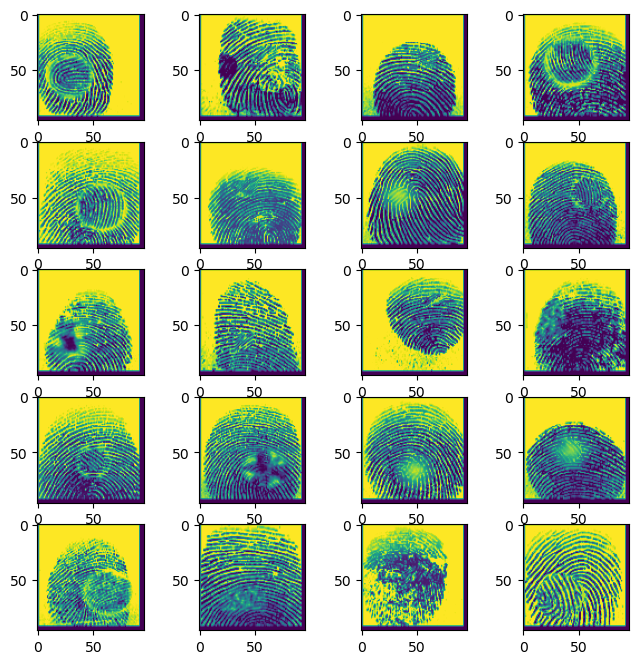

In [96]:
w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5

batch = next(iter(train_dataloader))
for i in range(1, columns * rows + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(batch['image'][i].permute(1, 2, 0))
plt.show()

### Check that now we have unified sizes.

In [97]:
sizes = set()
for sample in train_data:
    tens_to_img = transforms.ToPILImage()
    img = tens_to_img(sample['image'])
    sizes.add(img.size)

In [98]:
print(sizes)

{(96, 96)}


### Build model's architecture and train cycle.

### Based on the architecture of the FLDNet.

https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9079882

In [103]:
class FingerprintCNN(t.nn.Module):
    def __init__(self):
        super(FingerprintCNN, self).__init__()

        # Block 1: Convolution.
        # Conv 5x5 -> Batch Norm -> ReLU
        self.convolution = t.nn.Sequential(
            t.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(5, 5), stride=1)
        )

        # Block 2: D&R.
        # In the paper, D&R block consists of 4 layers, repeated 5 times. However, this will definitely lead to overfitting, so I will be using only 1 block one time.
        # Conv 3x3 -> Batch Norm -> ReLU -> Dropout 0.2
        self.dr = t.nn.Sequential(
            t.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), stride=1),
            t.nn.BatchNorm2d(num_features=16),
            t.nn.ReLU(),
            t.nn.Dropout(p=0.2)
        )
        
        # Block 3: Transition.
        # Conv 1x1 -> Batch Norm -> ReLU -> Dropout 0.2 -> AVG Pool 2x2
        self.transition = t.nn.Sequential(
            t.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=1),
            t.nn.ReLU(),
            t.nn.BatchNorm2d(num_features=32),
            t.nn.Dropout(p=0.2),
            t.nn.AvgPool2d(kernel_size=(2, 2), stride=2)
        )

        # Block 4: Classification.
        # As the researchers say, we can replace theirs "attention pooling" with a fully connected linear layer. For our task, it worked great.
        self.fc = t.nn.Sequential(
            t.nn.Linear(61952, 256),
            t.nn.ReLU(),
            t.nn.Dropout(0.1),
            t.nn.Linear(256, 10)
        )

    # x - batch of one or more tensors.
    def forward(self, x):
        
        # Block 1.
        z = self.convolution(x)

        # Block 2.
        z = self.dr(z)

        # Block 3.
        z = self.transition(z)

        # Block 4.
        z = t.flatten(z, start_dim=1)
        z = self.fc(z)
        z = t.nn.functional.log_softmax(z, dim=1)

        return z

In [104]:
model = FingerprintCNN().cuda()

epochs = 50
learning_rate = 0.01
criterion = t.nn.CrossEntropyLoss()
optimizer = t.optim.SGD(params=model.parameters(), lr=learning_rate)

In [101]:
def train_CNN(model, dataloaders, criterion, optimizer, num_epochs):
    since = time()

    f1_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    for epoch in tqdm(range(epochs), desc='Training Epochs'):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Decrease learning rate of optimiser by 20% every 7 epochs. 
        if epoch % 7 == 0:
            optimizer.param_groups[0]['lr'] = 0.001 * 0.8

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            epoch_labels = t.Tensor().to(device)
            epoch_predictions = t.Tensor().to(device)

            # Iterate over data.
            for dataloader in dataloaders[phase]:
                inputs = dataloader['image'].to(device)
                labels = dataloader['finger'].to(device)

                epoch_labels = t.cat((epoch_labels, labels))

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with t.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    predictions = t.argmax(outputs, dim=1)
                    epoch_predictions = t.cat((epoch_predictions, predictions))

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

            f1_epoch = f1_score(y_true=epoch_labels.cpu().detach().numpy(), y_pred=epoch_predictions.cpu().detach().numpy(), average='micro')

            accuracy_epoch = accuracy_score(y_true=epoch_labels.cpu().detach().numpy(), y_pred=epoch_predictions.cpu().detach().numpy())

            print('{} F1 score: {:.4f}, Accuracy: {:.4f}'.format(phase, f1_epoch, accuracy_epoch))

            # deep copy the model
            if phase == 'val' and f1_epoch > best_f1:
                best_f1 = f1_epoch
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                f1_history.append(f1_epoch)

        print()

    time_elapsed = time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best F1 score: {:4f}'.format(best_f1))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [105]:
dataloaders_dict = {'train': train_dataloader, 'val': validation_dataloader}

train_CNN(model, dataloaders_dict, criterion, optimizer, epochs)

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0/49
----------
train F1 score: 0.4293, Accuracy: 0.4293


Training Epochs:   2%|▏         | 1/50 [00:06<04:56,  6.06s/it]

val F1 score: 0.5157, Accuracy: 0.5157

Epoch 1/49
----------
train F1 score: 0.5777, Accuracy: 0.5777


Training Epochs:   4%|▍         | 2/50 [00:12<04:52,  6.10s/it]

val F1 score: 0.5927, Accuracy: 0.5927

Epoch 2/49
----------
train F1 score: 0.6476, Accuracy: 0.6476


Training Epochs:   6%|▌         | 3/50 [00:18<04:45,  6.08s/it]

val F1 score: 0.6280, Accuracy: 0.6280

Epoch 3/49
----------
train F1 score: 0.7097, Accuracy: 0.7097


Training Epochs:   8%|▊         | 4/50 [00:24<04:49,  6.29s/it]

val F1 score: 0.6790, Accuracy: 0.6790

Epoch 4/49
----------
train F1 score: 0.7572, Accuracy: 0.7572


Training Epochs:  10%|█         | 5/50 [00:30<04:39,  6.21s/it]

val F1 score: 0.7084, Accuracy: 0.7084

Epoch 5/49
----------
train F1 score: 0.7936, Accuracy: 0.7936


Training Epochs:  12%|█▏        | 6/50 [00:37<04:33,  6.21s/it]

val F1 score: 0.7424, Accuracy: 0.7424

Epoch 6/49
----------
train F1 score: 0.8251, Accuracy: 0.8251


Training Epochs:  14%|█▍        | 7/50 [00:43<04:24,  6.15s/it]

val F1 score: 0.7679, Accuracy: 0.7679

Epoch 7/49
----------
train F1 score: 0.8540, Accuracy: 0.8540


Training Epochs:  16%|█▌        | 8/50 [00:49<04:18,  6.14s/it]

val F1 score: 0.7705, Accuracy: 0.7705

Epoch 8/49
----------
train F1 score: 0.8781, Accuracy: 0.8781


Training Epochs:  18%|█▊        | 9/50 [00:55<04:15,  6.24s/it]

val F1 score: 0.7903, Accuracy: 0.7903

Epoch 9/49
----------
train F1 score: 0.8958, Accuracy: 0.8958


Training Epochs:  20%|██        | 10/50 [01:01<04:08,  6.21s/it]

val F1 score: 0.8279, Accuracy: 0.8279

Epoch 10/49
----------
train F1 score: 0.9142, Accuracy: 0.9142


Training Epochs:  22%|██▏       | 11/50 [01:07<04:01,  6.18s/it]

val F1 score: 0.8398, Accuracy: 0.8398

Epoch 11/49
----------
train F1 score: 0.9260, Accuracy: 0.9260


Training Epochs:  24%|██▍       | 12/50 [01:14<03:53,  6.15s/it]

val F1 score: 0.8527, Accuracy: 0.8527

Epoch 12/49
----------
train F1 score: 0.9407, Accuracy: 0.9407


Training Epochs:  26%|██▌       | 13/50 [01:20<03:47,  6.15s/it]

val F1 score: 0.8660, Accuracy: 0.8660

Epoch 13/49
----------
train F1 score: 0.9484, Accuracy: 0.9484


Training Epochs:  28%|██▊       | 14/50 [01:26<03:40,  6.12s/it]

val F1 score: 0.8807, Accuracy: 0.8807

Epoch 14/49
----------
train F1 score: 0.9591, Accuracy: 0.9591


Training Epochs:  30%|███       | 15/50 [01:32<03:36,  6.20s/it]

val F1 score: 0.8789, Accuracy: 0.8789

Epoch 15/49
----------
train F1 score: 0.9619, Accuracy: 0.9619


Training Epochs:  32%|███▏      | 16/50 [01:38<03:30,  6.21s/it]

val F1 score: 0.8944, Accuracy: 0.8944

Epoch 16/49
----------
train F1 score: 0.9702, Accuracy: 0.9702


Training Epochs:  34%|███▍      | 17/50 [01:44<03:23,  6.16s/it]

val F1 score: 0.9062, Accuracy: 0.9062

Epoch 17/49
----------
train F1 score: 0.9753, Accuracy: 0.9753


Training Epochs:  36%|███▌      | 18/50 [01:51<03:16,  6.15s/it]

val F1 score: 0.9060, Accuracy: 0.9060

Epoch 18/49
----------
train F1 score: 0.9796, Accuracy: 0.9796


Training Epochs:  38%|███▊      | 19/50 [01:57<03:09,  6.13s/it]

val F1 score: 0.9137, Accuracy: 0.9137

Epoch 19/49
----------
train F1 score: 0.9807, Accuracy: 0.9807


Training Epochs:  40%|████      | 20/50 [02:03<03:04,  6.16s/it]

val F1 score: 0.9127, Accuracy: 0.9127

Epoch 20/49
----------
train F1 score: 0.9845, Accuracy: 0.9845


Training Epochs:  42%|████▏     | 21/50 [02:09<02:57,  6.13s/it]

val F1 score: 0.9201, Accuracy: 0.9201

Epoch 21/49
----------
train F1 score: 0.9874, Accuracy: 0.9874


Training Epochs:  44%|████▍     | 22/50 [02:15<02:52,  6.14s/it]

val F1 score: 0.9353, Accuracy: 0.9353

Epoch 22/49
----------
train F1 score: 0.9874, Accuracy: 0.9874


Training Epochs:  46%|████▌     | 23/50 [02:21<02:45,  6.12s/it]

val F1 score: 0.9351, Accuracy: 0.9351

Epoch 23/49
----------
train F1 score: 0.9904, Accuracy: 0.9904


Training Epochs:  48%|████▊     | 24/50 [02:27<02:38,  6.11s/it]

val F1 score: 0.9194, Accuracy: 0.9194

Epoch 24/49
----------
train F1 score: 0.9916, Accuracy: 0.9916


Training Epochs:  50%|█████     | 25/50 [02:34<02:36,  6.24s/it]

val F1 score: 0.9366, Accuracy: 0.9366

Epoch 25/49
----------
train F1 score: 0.9925, Accuracy: 0.9925


Training Epochs:  52%|█████▏    | 26/50 [02:40<02:28,  6.20s/it]

val F1 score: 0.9389, Accuracy: 0.9389

Epoch 26/49
----------
train F1 score: 0.9929, Accuracy: 0.9929


Training Epochs:  54%|█████▍    | 27/50 [02:46<02:22,  6.19s/it]

val F1 score: 0.9456, Accuracy: 0.9456

Epoch 27/49
----------
train F1 score: 0.9945, Accuracy: 0.9945


Training Epochs:  56%|█████▌    | 28/50 [02:52<02:15,  6.14s/it]

val F1 score: 0.9454, Accuracy: 0.9454

Epoch 28/49
----------
train F1 score: 0.9946, Accuracy: 0.9946


Training Epochs:  58%|█████▊    | 29/50 [02:58<02:09,  6.15s/it]

val F1 score: 0.9438, Accuracy: 0.9438

Epoch 29/49
----------
train F1 score: 0.9952, Accuracy: 0.9952


Training Epochs:  60%|██████    | 30/50 [03:05<02:04,  6.22s/it]

val F1 score: 0.9482, Accuracy: 0.9482

Epoch 30/49
----------
train F1 score: 0.9960, Accuracy: 0.9960


Training Epochs:  62%|██████▏   | 31/50 [03:11<01:57,  6.20s/it]

val F1 score: 0.9487, Accuracy: 0.9487

Epoch 31/49
----------
train F1 score: 0.9968, Accuracy: 0.9968


Training Epochs:  64%|██████▍   | 32/50 [03:17<01:51,  6.17s/it]

val F1 score: 0.9464, Accuracy: 0.9464

Epoch 32/49
----------
train F1 score: 0.9965, Accuracy: 0.9965


Training Epochs:  66%|██████▌   | 33/50 [03:23<01:44,  6.15s/it]

val F1 score: 0.9523, Accuracy: 0.9523

Epoch 33/49
----------
train F1 score: 0.9972, Accuracy: 0.9972


Training Epochs:  68%|██████▊   | 34/50 [03:29<01:38,  6.13s/it]

val F1 score: 0.9541, Accuracy: 0.9541

Epoch 34/49
----------
train F1 score: 0.9975, Accuracy: 0.9975


Training Epochs:  70%|███████   | 35/50 [03:36<01:33,  6.26s/it]

val F1 score: 0.9516, Accuracy: 0.9516

Epoch 35/49
----------
train F1 score: 0.9975, Accuracy: 0.9975


Training Epochs:  72%|███████▏  | 36/50 [03:42<01:26,  6.21s/it]

val F1 score: 0.9544, Accuracy: 0.9544

Epoch 36/49
----------
train F1 score: 0.9976, Accuracy: 0.9976


Training Epochs:  74%|███████▍  | 37/50 [03:48<01:20,  6.17s/it]

val F1 score: 0.9552, Accuracy: 0.9552

Epoch 37/49
----------
train F1 score: 0.9984, Accuracy: 0.9984


Training Epochs:  76%|███████▌  | 38/50 [03:54<01:13,  6.15s/it]

val F1 score: 0.9539, Accuracy: 0.9539

Epoch 38/49
----------
train F1 score: 0.9976, Accuracy: 0.9976


Training Epochs:  78%|███████▊  | 39/50 [04:00<01:07,  6.13s/it]

val F1 score: 0.9534, Accuracy: 0.9534

Epoch 39/49
----------
train F1 score: 0.9981, Accuracy: 0.9981


Training Epochs:  80%|████████  | 40/50 [04:07<01:02,  6.26s/it]

val F1 score: 0.9549, Accuracy: 0.9549

Epoch 40/49
----------
train F1 score: 0.9983, Accuracy: 0.9983


Training Epochs:  82%|████████▏ | 41/50 [04:13<00:56,  6.29s/it]

val F1 score: 0.9570, Accuracy: 0.9570

Epoch 41/49
----------
train F1 score: 0.9983, Accuracy: 0.9983


Training Epochs:  84%|████████▍ | 42/50 [04:19<00:49,  6.22s/it]

val F1 score: 0.9570, Accuracy: 0.9570

Epoch 42/49
----------
train F1 score: 0.9986, Accuracy: 0.9986


Training Epochs:  86%|████████▌ | 43/50 [04:25<00:43,  6.19s/it]

val F1 score: 0.9567, Accuracy: 0.9567

Epoch 43/49
----------
train F1 score: 0.9986, Accuracy: 0.9986


Training Epochs:  88%|████████▊ | 44/50 [04:31<00:37,  6.17s/it]

val F1 score: 0.9580, Accuracy: 0.9580

Epoch 44/49
----------
train F1 score: 0.9985, Accuracy: 0.9985


Training Epochs:  90%|█████████ | 45/50 [04:38<00:31,  6.23s/it]

val F1 score: 0.9575, Accuracy: 0.9575

Epoch 45/49
----------
train F1 score: 0.9989, Accuracy: 0.9989


Training Epochs:  92%|█████████▏| 46/50 [04:44<00:24,  6.23s/it]

val F1 score: 0.9572, Accuracy: 0.9572

Epoch 46/49
----------
train F1 score: 0.9993, Accuracy: 0.9993


Training Epochs:  94%|█████████▍| 47/50 [04:50<00:18,  6.20s/it]

val F1 score: 0.9580, Accuracy: 0.9580

Epoch 47/49
----------
train F1 score: 0.9988, Accuracy: 0.9988


Training Epochs:  96%|█████████▌| 48/50 [04:56<00:12,  6.20s/it]

val F1 score: 0.9590, Accuracy: 0.9590

Epoch 48/49
----------
train F1 score: 0.9992, Accuracy: 0.9992


Training Epochs:  98%|█████████▊| 49/50 [05:02<00:06,  6.14s/it]

val F1 score: 0.9596, Accuracy: 0.9596

Epoch 49/49
----------
train F1 score: 0.9992, Accuracy: 0.9992


Training Epochs: 100%|██████████| 50/50 [05:08<00:00,  6.18s/it]

val F1 score: 0.9596, Accuracy: 0.9596

Training complete in 5m 9s
Best F1 score: 0.959557


FingerprintCNN(
  (convolution): Sequential(
    (0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1))
  )
  (dr): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (transition): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  )
  (fc): Sequential(
    (0): Linear(in_features=61952, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

### Testing the model on the test dataset.

In [106]:
test_labels = t.Tensor().to(device)
test_predictions = t.Tensor().to(device)

# Iterate over data.
for batch_sample in test_dataloader:
    inputs = batch_sample['image'].to(device)
    labels = batch_sample['finger'].to(device)

    test_labels = t.cat((test_labels, labels))

    # Get model outputs and calculate loss.
    outputs = model(inputs)

    predictions = t.argmax(outputs, dim=1)
    test_predictions = t.cat((test_predictions, predictions))

test_f1_score = f1_score(y_true=test_labels.cpu().detach().numpy(), y_pred=test_predictions.cpu().detach().numpy(), average='micro')

print('F1 score: {:.4f}'.format(test_f1_score))

F1 score: 0.9119


### Questions
1. What preprocessing techniques did you use? Why?
    - First, I have extracted all the data from zip into the custom dataset class. 
    - Second, I have made dataloaders with batch size = 32.
    - Lastly, I have split the data into the train, validation, and test dataloaders, and applied data augmentation on them.
2. What data augmentation techniques did you use?
    - In this document you can find detail descriptions of the steps I've made.
    https://docs.google.com/document/d/1f9QW9_cxDBiuL03onNK-5qAGeXzot0QgLxLpgD5GbXw/edit?usp=sharing
3. Describe the fine-tuning process and how you reached your final CNN model.
    - In this document you can find detail descriptions of the steps I've made.
    https://docs.google.com/document/d/1f9QW9_cxDBiuL03onNK-5qAGeXzot0QgLxLpgD5GbXw/edit?usp=sharing
4. What techniques did you use to improve model’s performance other than data augmentation
    - I have generalised my model with inclusion of AvgPool2d, it calculates the average of cells and outputs it. It used to extract higher order information.

# Task 3: Credit approval (15 points)

Credit approval is necessary to assess an individual's creditworthiness and determine their eligibility for loans, credit cards, and other financial products. It helps lenders to evaluate the borrower's ability to repay the loan, their credit history, and other financial obligations.
Credit approval is important for both lenders and borrowers because it enables lenders to manage their risk and make informed lending decisions while ensuring that borrowers can obtain financing on fair and reasonable terms.

In many credit approval applications, it is crucial for the model to be interpretable. This means that the model's inner workings and decision-making process can be easily understood and explained by humans. An interpretable model can help to build trust in the model's output, provide transparency in the decision-making process, and enable regulators to monitor and audit the model's performance. 

## What you need to do

For the `loan_data.csv` data, predict if the bank should give a loan or not.

- Fine-tune a decision tree on the data
- Fine-tune a random forest on the data
- Compare their performance
- Visualize your DT and one of the trees from the RF

For evaluating your models, do $80/20$ train test split.

### Learning Objectives

- Apply DTs, and RFs to solve a classification problem (basic training, validation, testing). 50%
- Fine-tune to determine the optimal model architecture. 20%
- Evaluate and compare the performance of different models. 10%
- Visualise the models. 20%


### Data
- `credit.policy`: Whether the customer meets the credit underwriting criteria.
- `purpose`: The purpose of the loan.
- `int.rate`: The interest rate of the loan.
- `installment`: The monthly installments owed by the borrower if the loan is funded.
- `log.annual.inc`: The natural logarithm of the self-reported annual income of the borrower.
- `dti`: The debt-to-income ratio of the borrower.
- `fico`: The FICO credit score of the borrower.
- `days.with.cr.line`: The number of days the borrower has had a credit line.
- `revol.bal`: The borrower's revolving balance.
- `revol.util`: The borrower's revolving line utilization rate.

In [143]:
credit_df = pd.read_csv("/kaggle/input/imls23-assignment2/loan_data.csv")
credit_df

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,all_other,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1
9574,0,all_other,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1
9575,0,debt_consolidation,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,1
9576,0,home_improvement,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,1


In [144]:
y = credit_df['credit.policy']
X = credit_df.drop('credit.policy', axis='columns')
X

,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,all_other,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1
9574,all_other,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1
9575,debt_consolidation,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,1
9576,home_improvement,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,1


### Check class balance.

[Text(0, 0, '1868'), Text(0, 0, '7710')]

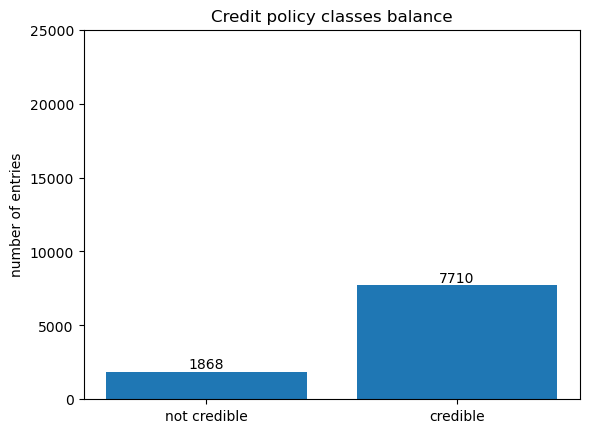

In [146]:
credible = y.loc[lambda x: x == 1]
not_credible = y.loc[lambda x: x == 0]

fig, ax = plt.subplots()
bar_container = ax.bar(['not credible', 'credible'], [len(not_credible), len(credible)])
ax.set(ylabel='number of entries', title='Credit policy classes balance', ylim=(0, 25000))
ax.bar_label(bar_container)

### The dataset is unbalanced, so we should account both False Positives, as well as False Negatives, that is why I will be optimising the f1 score metric.

### One-hot encode columns

In [147]:
transformer = make_column_transformer(
    (OneHotEncoder(), ['purpose']),
    remainder='passthrough'
)

transformed = transformer.fit_transform(X)
transformed_X = pd.DataFrame(
    transformed,
    columns=transformer.get_feature_names_out()
)
transformed_X

,onehotencoder__purpose_all_other,onehotencoder__purpose_credit_card,onehotencoder__purpose_debt_consolidation,onehotencoder__purpose_educational,onehotencoder__purpose_home_improvement,onehotencoder__purpose_major_purchase,onehotencoder__purpose_small_business,remainder__int.rate,remainder__installment,remainder__log.annual.inc,remainder__dti,remainder__fico,remainder__days.with.cr.line,remainder__revol.bal,remainder__revol.util,remainder__inq.last.6mths,remainder__delinq.2yrs,remainder__pub.rec,remainder__not.fully.paid
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.1189,829.10,11.350407,19.48,737.0,5639.958333,28854.0,52.1,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.1071,228.22,11.082143,14.29,707.0,2760.000000,33623.0,76.7,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.1357,366.86,10.373491,11.63,682.0,4710.000000,3511.0,25.6,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.1008,162.34,11.350407,8.10,712.0,2699.958333,33667.0,73.2,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.1426,102.92,11.299732,14.97,667.0,4066.000000,4740.0,39.5,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1461,344.76,12.180755,10.39,672.0,10474.000000,215372.0,82.1,2.0,0.0,0.0,1.0
9574,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1253,257.70,11.141862,0.21,722.0,4380.000000,184.0,1.1,5.0,0.0,0.0,1.0
9575,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.1071,97.81,10.596635,13.09,687.0,3450.041667,10036.0,82.9,8.0,0.0,0.0,1.0
9576,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.1600,351.58,10.819778,19.18,692.0,1800.000000,0.0,3.2,5.0,0.0,0.0,1.0


### Check the data correlation.

In [148]:
plt.figure(figsize=(30, 30))
corr = transformed_X.corr()
corr.style.format(precision=2).background_gradient(cmap='Oranges')

,onehotencoder__purpose_all_other,onehotencoder__purpose_credit_card,onehotencoder__purpose_debt_consolidation,onehotencoder__purpose_educational,onehotencoder__purpose_home_improvement,onehotencoder__purpose_major_purchase,onehotencoder__purpose_small_business,remainder__int.rate,remainder__installment,remainder__log.annual.inc,remainder__dti,remainder__fico,remainder__days.with.cr.line,remainder__revol.bal,remainder__revol.util,remainder__inq.last.6mths,remainder__delinq.2yrs,remainder__pub.rec,remainder__not.fully.paid
onehotencoder__purpose_all_other,1.00,-0.22,-0.48,-0.11,-0.15,-0.12,-0.15,-0.12,-0.20,-0.08,-0.13,0.07,-0.06,-0.07,-0.14,0.02,0.02,-0.03,0.01
onehotencoder__purpose_credit_card,-0.22,1.00,-0.33,-0.08,-0.10,-0.09,-0.10,-0.04,0.00,0.07,0.08,-0.01,0.05,0.07,0.09,-0.03,-0.01,0.01,-0.05
onehotencoder__purpose_debt_consolidation,-0.48,-0.33,1.00,-0.16,-0.22,-0.18,-0.22,0.12,0.16,-0.03,0.18,-0.15,-0.01,0.01,0.21,-0.04,-0.00,0.03,-0.02
onehotencoder__purpose_educational,-0.11,-0.08,-0.16,1.00,-0.05,-0.04,-0.05,-0.02,-0.09,-0.12,-0.04,-0.01,-0.04,-0.03,-0.05,0.02,-0.00,-0.01,0.02
onehotencoder__purpose_home_improvement,-0.15,-0.10,-0.22,-0.05,1.00,-0.06,-0.07,-0.05,0.02,0.12,-0.09,0.10,0.07,0.00,-0.11,0.04,-0.01,0.00,0.01
onehotencoder__purpose_major_purchase,-0.12,-0.09,-0.18,-0.04,-0.06,1.00,-0.06,-0.07,-0.08,-0.03,-0.08,0.07,-0.02,-0.06,-0.11,-0.00,0.00,-0.01,-0.03
onehotencoder__purpose_small_business,-0.15,-0.10,-0.22,-0.05,-0.07,-0.06,1.00,0.15,0.15,0.09,-0.07,0.06,0.03,0.08,-0.06,0.04,-0.00,-0.01,0.08
remainder__int.rate,-0.12,-0.04,0.12,-0.02,-0.05,-0.07,0.15,1.00,0.28,0.06,0.22,-0.71,-0.12,0.09,0.46,0.20,0.16,0.10,0.16
remainder__installment,-0.20,0.00,0.16,-0.09,0.02,-0.08,0.15,0.28,1.00,0.45,0.05,0.09,0.18,0.23,0.08,-0.01,-0.00,-0.03,0.05
remainder__log.annual.inc,-0.08,0.07,-0.03,-0.12,0.12,-0.03,0.09,0.06,0.45,1.00,-0.05,0.11,0.34,0.37,0.05,0.03,0.03,0.02,-0.03


<Figure size 3000x3000 with 0 Axes>

### I have found the correlation of -0.71 between 'fice' and 'int.rate'. For now, I will leave them as it is, but if I wwill see any strange behaviour in predictions, then I will remove those features.

In [149]:
X_train, X_test, y_train, y_test = train_test_split(transformed_X, y, test_size=0.2, random_state=42, stratify=y)

### Finetunning decision tree.

references:

https://www.projectpro.io/recipes/optimize-hyper-parameters-of-decisiontree-model-using-grid-search-in-python

In [150]:
dec_tree = tree.DecisionTreeClassifier()
criterion = ['gini', 'entropy', 'log_loss']
max_depth = [i for i in range(2, 51, 2)]
splitter = ['best', 'random']
parameters = {'criterion': criterion,
              'max_depth': max_depth,
              'splitter': splitter}

clf_GS = GridSearchCV(estimator=dec_tree, param_grid=parameters)
clf_GS.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
250 fits failed out of a total of 750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
250 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/opt/conda/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

  warnings.warn(some_fits_failed_m

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22,
                                       24, 26, 28, 30, 32, 34, 36, 38, 40, 42,
                                       44, 46, 48, 50],
                         'splitter': ['best', 'random']})

In [151]:
print('Best Criterion:', clf_GS.best_estimator_.get_params()['criterion'])
print('Best max_depth:', clf_GS.best_estimator_.get_params()['max_depth'])
print('Best max_depth:', clf_GS.best_estimator_.get_params()['splitter'])

Best Criterion: entropy
Best max_depth: 10
Best max_depth: best


### Create and fit a Decision Tree Classifier.

references:

https://scikit-learn.org/stable/modules/tree.html

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier


In [152]:
dec_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10, splitter='best')
dec_tree = dec_tree.fit(X_train, y_train)

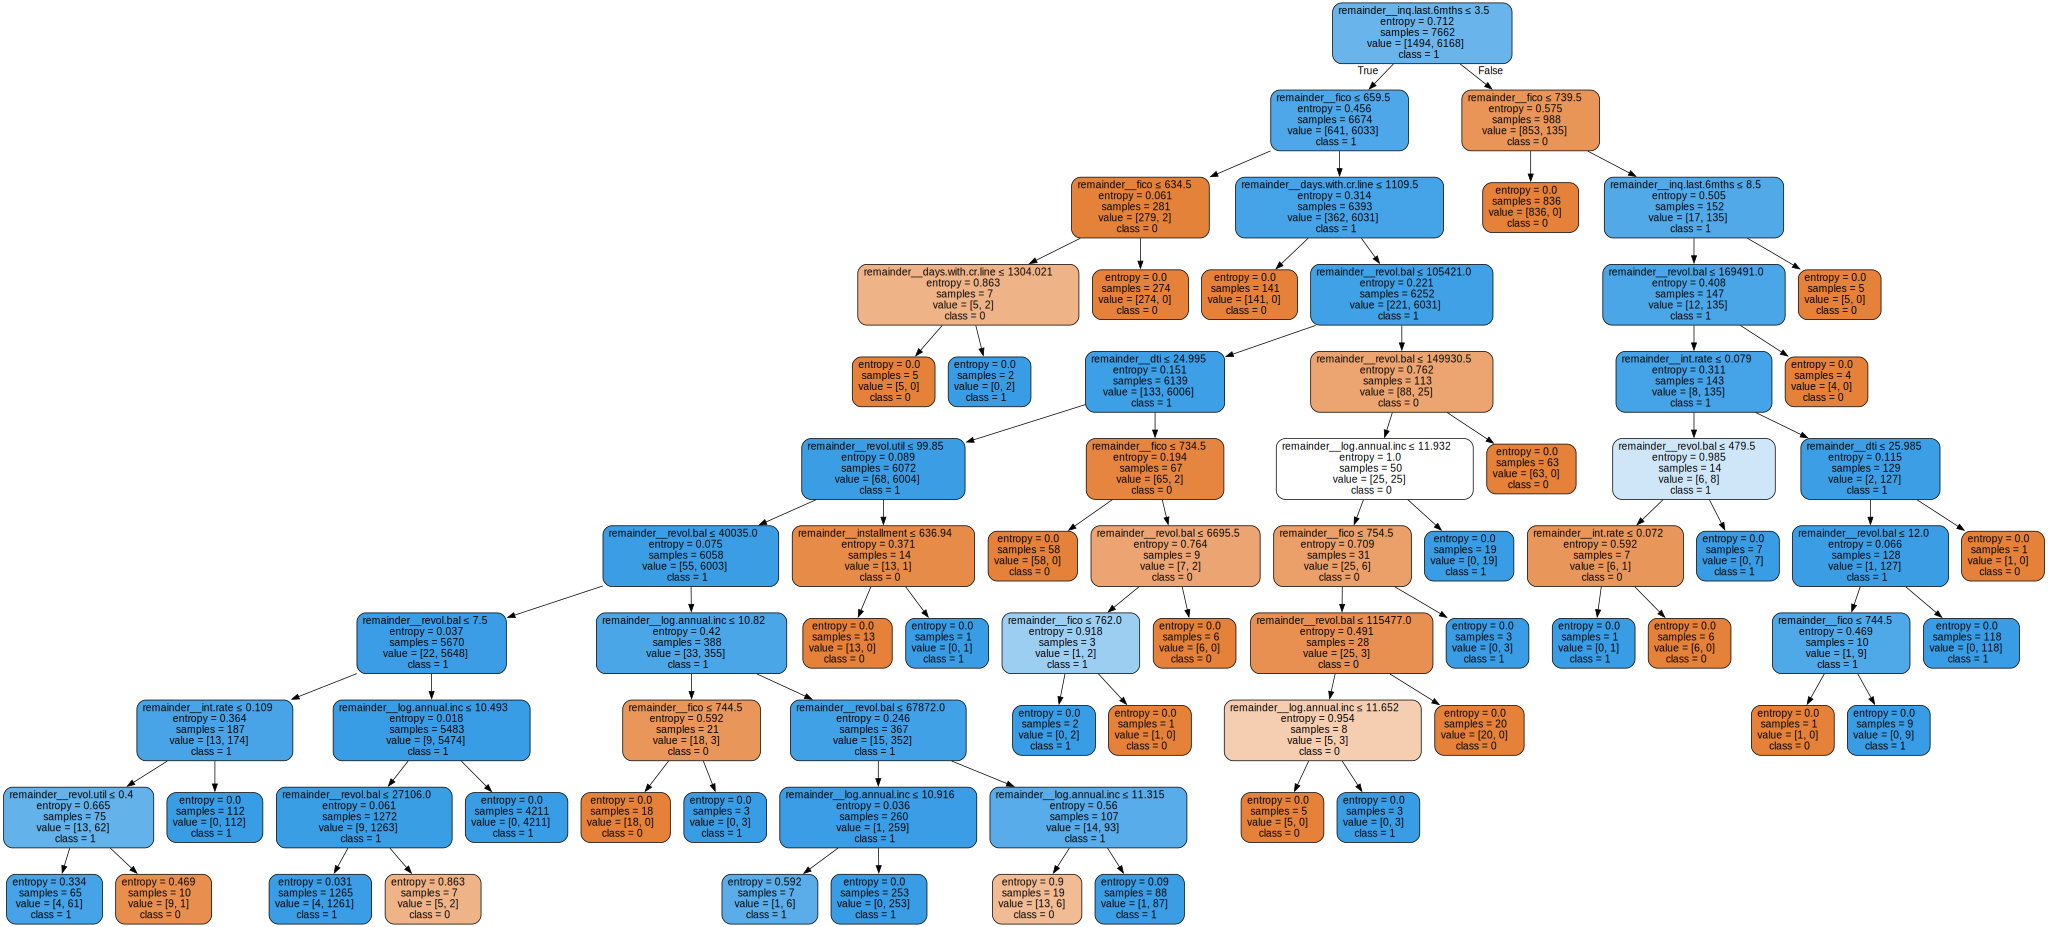

In [153]:
dot_data = tree.export_graphviz(dec_tree, out_file=None, 
                     feature_names=X_train.columns,  
                     class_names=['0', '1'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

### Construct and finetune the Random Forest.

### Atention: Fine-tunning takes 1 hour and a half.

In [ ]:
# rand_forest = RandomForestClassifier()
# n_estimators = [i for i in range (100, 301, 100)]
# parameters = {'n_estimators': n_estimators,
#               'criterion': criterion,
#               'max_depth': max_depth}

# clf_GS = GridSearchCV(estimator=rand_forest, param_grid=parameters, verbose=True)
# clf_GS.fit(X_train, y_train)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22,
                                       24, 26, 28, 30, 32, 34, 36, 38, 40, 42,
                                       44, 46, 48, 50, 52, 54, 56, 58, 60, ...],
                         'n_estimators': [100, 200, 300]},
             verbose=True)

In [ ]:
print('Best n_estimators:', clf_GS.best_estimator_.get_params()['n_estimators'])
print('Best criterion:', clf_GS.best_estimator_.get_params()['criterion'])
print('Best max_depth:', clf_GS.best_estimator_.get_params()['max_depth'])

Best n_estimators: 200

Best criterion: gini

Best max_depth: 38


In [154]:
rand_forest = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=38)
rand_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=38, n_estimators=200)

### Visualising the first decision tree of RF.

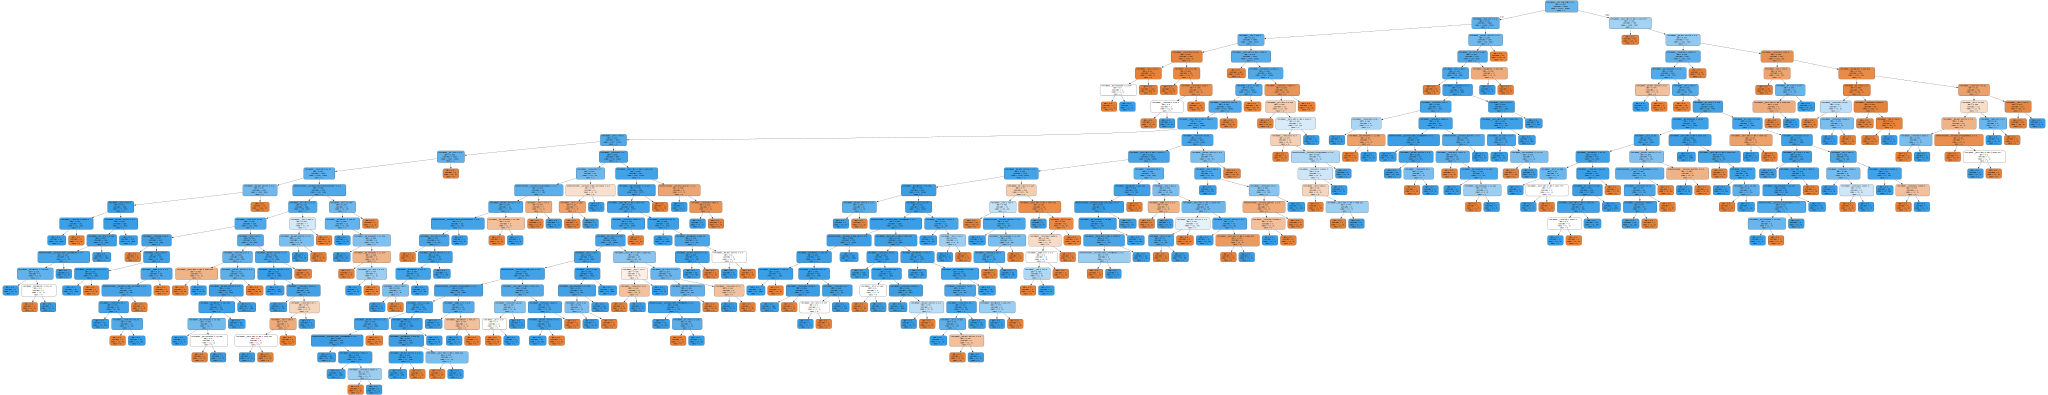

In [155]:
dot_data = tree.export_graphviz(rand_forest.estimators_[0], out_file=None, 
                     feature_names=X_train.columns,  
                     class_names=['0', '1'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

### Comparing performances of Decision Tree and Random Forest.

In [156]:
dec_tree_pred = dec_tree.predict(X_test)
rand_forest_pred = rand_forest.predict(X_test)

dec_tree_f1 = f1_score(y_true=y_test, y_pred=dec_tree_pred)
rand_forest_f1 = f1_score(y_true=y_test, y_pred=rand_forest_pred)

print("Decision tree f1 score: ", dec_tree_f1)
print("Random forest f1 score: ", rand_forest_f1)

Decision tree f1 score:  0.9928617780661909
Random forest f1 score:  0.9919328815747015


### Questions
1. How did the DT compare to the RF in performance? Why?
    - In my case, DT has shown a slightly better performance than RF because the task was not that complex for usage of the RF comprised of many DTs.
2. After fine-tuning, how does the max depth in DT compare to RF? Why?
    - After fine-tuning, max_depth for RF increased in more than 3 times compared to the Decision Tree Classifier with *max_depth* = 12.
    - This happened because Random Forest is comprised of many decision trees, which make a prediction, and then vote for the optimal one. 
    - Thus, we shouldn't depend on correlated trees because they will be giving the same predictions, so we should increase the complexity of the DTs.
3. What is ensemble learning? What are its pros and cons?
    - Ensemble learning is a method for making a prediction with use of several models (ensembles).
    - Advantages: 
    -- Individual models might stuck in the local minimum, but taking the average of theirs predictions will help to avoid this problem.
    -- Each model takes a small piece of data, decreasing the learning time.
    -- Unified models tend to not cover the larger space for finding the real solution. Splitting the data among many different models allows to expand the solution space of the models.
    - Disadvantages:
    -- Ensembles are difficult to interpret.
    -- Selecting models into an ensemble requires deep analysis, and might be difficult to pull off in the first place.
4. Briefly explain 2 types of boosting methods and 2 types of bagging methods.
Which of these categories does RF fall under?
    - Boosting:
    -- AdaBoost - this method creates a model while assigning each data point an equal weight. Then, it gives points that were incorrectly categorised larger weights. In the following model, all the points with greater weights are now assigned more relevance. It will continue to train models until a smaller error is seen.
    -- Gradient Boosting - the primary concept underlying this method is to create models in succession while attempting to minimize the flaws of the prior model. This is accomplished by building a new model on the mistakes or residuals of the prior one.
    - Bagging:
    -- Bagging - is a general method that may be used to lower the variance for high variance algorithms. Decision trees, which are used in algorithms for classification and regression, have a large variance.
    -- Random Forest - predictions from the sub-models should be uncorrelated or, at worst, minimally linked in order for predictions from several models to be combined effectively. As a result of changing the technique used to train the subtrees, random forest produces predictions from all of the subtrees that are less correlated with one another.